# CIFAR-10 dataset classification with MLPs

Author: Tanwi Mallick, adapting codes from Bethany Lusch, Prasanna Balprakash, Corey Adams, and Kyle Felker

In this notebook, we'll continue the CIFAR-10 problem but using the Keras API (as included in the TensorFlow library)

First, the needed imports.

In [7]:
%matplotlib inline

import tensorflow as tf

import numpy
import matplotlib.pyplot as plt
import time

## CIFAR-10 data set

Again we'll load the cifar10 data set. CIFAR-10 dataset contains 32x32 color images from 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. If you haven't downloaded it already, it could take a while.

<img src="images/CIFAR-10.png"  align="left"/>

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype(numpy.float32)
x_test  = x_test.astype(numpy.float32)

x_train /= 255.
x_test  /= 255.

y_train = y_train.astype(numpy.int32)
y_test  = y_test.astype(numpy.int32)

print()
print('CIFAR-10 data loaded: train:',len(x_train),'test:',len(x_test))
print('X_train:', x_train.shape)
print('y_train:', y_train.shape)


CIFAR-10 data loaded: train: 50000 test: 10000
X_train: (50000, 32, 32, 3)
y_train: (50000, 1)


### Download the dataset and load

In [4]:
!pip install image-dataset-loader
!wget https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz
!tar -xf cifar10.tgz

You should consider upgrading via the '/Users/tanwimallick/anaconda3/bin/python -m pip install --upgrade pip' command.


In [5]:
from image_dataset_loader import load
(x_train, y_train), (x_test, y_test) = load('cifar10', ['train', 'test'])

x_train = x_train.astype(numpy.float32)
x_test  = x_test.astype(numpy.float32)

x_train /= 255.
x_test  /= 255.

y_train = y_train.astype(numpy.int32)
y_test  = y_test.astype(numpy.int32)

print()
print('CIFAR-10 data loaded: train:',len(x_train),'test:',len(x_test))
print('X_train:', x_train.shape)
print('y_train:', y_train.shape)

This time we won't flatten the images upfront. 

The training data (`X_train`) is a 3rd-order tensor of size (50000, 32, 32), i.e. it consists of 50000 images of size 32x32 pixels. 

`y_train` is a 50000-dimensional vector containing the correct classes ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') for each training sample.

<img src="images/image_representation.png"  align="left"/>

## Linear model

### Initialization

Let's begin with a simple linear model, but with the Keras library. First we use a `Flatten` layer to convert image data into vectors. 

A `Dense()` layer is a basic layer: $xW + b$ with an optional nonlinearity applied ("activation function"). The `Dense` layer connects each input to each output with some weight parameter. They are also called "fully connected."

Here we add a `Dense` layer that has $32\times32\times3=3072$ input nodes (one for each pixel in the input image) and 10 output nodes. 

In [4]:
class LinearClassifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        self.layer_1 = tf.keras.layers.Dense(10, activation='softmax')


    def call(self, inputs):

        x = tf.keras.layers.Flatten()(inputs)
        x = self.layer_1(x)

        return x

We select *sparse categorical crossentropy* as the loss function, select [*stochastic gradient descent*](https://keras.io/optimizers/#sgd) as the optimizer, add *accuracy* to the list of metrics to be evaluated, and `compile()` the model. Note there are [several different options](https://keras.io/optimizers/) for the optimizer in Keras that we could use instead of *sgd*.

In [5]:
linear_model = LinearClassifier()

linear_model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=['accuracy'])

### Learning

Now we are ready to train our first model. An epoch means one pass through the whole training data.

Here is a concise way to train the network. The fit function handles looping over the batches. We'll see a more verbose approach in the next notebook that allows more performance tuning.

You can run the code below multiple times and it will continue the training process from where it left off. If you want to start from scratch, re-initialize the model using the code a few cells ago.

In [6]:
%%time
# This took about a third of a second per epoch on my laptop
batch_size = 512
epochs = 30
history = linear_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2)

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing t

In [7]:
print(linear_model.summary())

Model: "linear_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  30730     
                                                                 
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
_________________________________________________________________
None


The summary shows that there are 30730 parameters in our model, as the weight matrix is of size 3072x10, plus there's a bias vector of 10x1.

Let's now see how the training progressed. 

* *Loss* is a function of the difference of the network output and the target values.  We are minimizing the loss function during training so it should decrease over time.
* *Accuracy* is the classification accuracy for the training data (100*accuracy is the percentage labeled correctly), so it should increase over time

Note that for either measure, we cannot fully trust the progress, as the model may have overfitted and just memorized the training data.

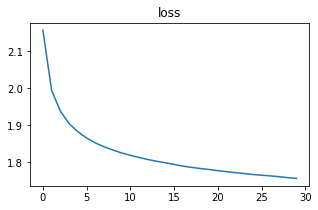

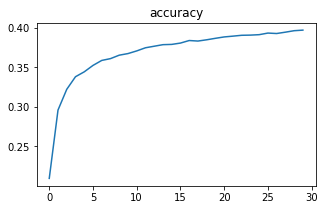

In [8]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

### Inference

For a better measure of the quality of the model, let's see the model accuracy for the test data. 

In [10]:
linscores = linear_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (linear_model.metrics_names[1], linscores[1]*100))

313/313 - 0s - loss: 1.7684 - accuracy: 0.3918 - 180ms/epoch - 574us/step
accuracy: 39.18%


We can now take a closer look on the results.

Let's define a helper function to show the failure cases of our classifier. 

In [59]:
def show_failures(predictions, trueclass=None, predictedclass=None, maxtoshow=20):
    rounded = numpy.argmax(predictions, axis=1)
    errors = rounded!=y_test.flatten()
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parenthesis.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(x_test.shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            if trueclass is not None and y_test[i] != trueclass:
                continue
            if predictedclass is not None and rounded[i] != predictedclass:
                continue
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(x_test[i,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], y_test[i]))
            ii = ii + 1

Here are the first 10 test images the linear model classified to a wrong class:

Showing max 20 first failures. The predicted class is shown first and the correct class in parenthesis.


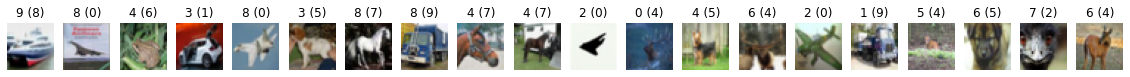

In [60]:
linpredictions = linear_model.predict(x_test)

show_failures(linpredictions)

## Multi-layer perceptron (MLP) network

### Initialization

Let's now create a more complex MLP model that has multiple layers, non-linear activation functions, and dropout layers. 

`Dropout()` randomly sets a fraction of inputs to zero during training, which is one approach to regularization and can sometimes help to prevent overfitting. 

There are two options below, a simple and a bit more complex model.  Select either one.

The output of the last layer needs to be a softmaxed 10-dimensional vector to match the groundtruth (`y_train`). 

In [97]:
class NonlinearClassifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        self.layer_1 = tf.keras.layers.Dense(50, activation='relu')
        
#         # A bit more complex model: (need to uncomment in call fn as well)
#         self.layer_2 = tf.keras.layers.Dense(50, activation='relu')
#         self.drop_3 = tf.keras.layers.Dropout(0.2)
#         self.layer_4 = tf.keras.layers.Dense(50, activation='relu')
#         self.drop_5 = tf.keras.layers.Dropout(0.2)
        
        # The last layer needs to be like this:
        self.layer_out = tf.keras.layers.Dense(10, activation='softmax')


    def call(self, inputs):

        x = tf.keras.layers.Flatten()(inputs)
        x = self.layer_1(x)
        
        # The more complex version:
        #x = self.layer_2(x)
        #x = self.drop_3(x)
        #x = self.layer_4(x)
        #x = self.drop_5(x)
        
        x = self.layer_out(x)

        return x

Finally, we again `compile()` the model, this time using [*RMSProp*](https://keras.io/optimizers/#rmsprop) as the optimizer.

In [98]:
nonlinear_model = NonlinearClassifier()

nonlinear_model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=['accuracy'])

### Learning

In [99]:
%%time
# This took around half a second per epoch on my laptop for the simpler version, 
# and around 1 second per epoch for the more complex one.
batch_size = 512
epochs = 30
history = nonlinear_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2)

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing t

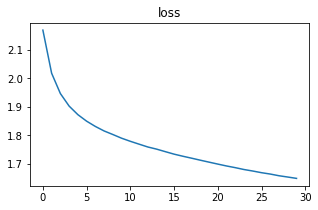

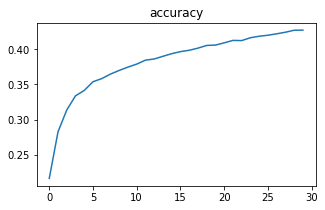

In [100]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

### Inference

Accuracy for test data.  The model should be better than the linear model. 

In [101]:
%%time
scores = nonlinear_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (nonlinear_model.metrics_names[1], scores[1]*100))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
313/313 - 0s - loss: 1.6671 - accuracy: 0.4184 - 324ms/epoch - 1ms/step
accuracy: 41.84%
CPU times: user 661 ms, sys: 93.2 ms, total: 754 ms
Wall time: 400 ms


We can again take a closer look on the results, using the `show_failures()` function defined earlier.

Here are the first 10 test images the MLP classified to a wrong class:

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Showing max 20 first failures. The predicted class is shown first and the correct class in parenthesis.


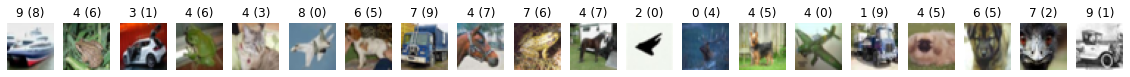

In [102]:
predictions = nonlinear_model.predict(x_test)

show_failures(predictions)

We can use `show_failures()` to inspect failures in more detail. For example, here are failures in which the true class was "6":

Showing max 20 first failures. The predicted class is shown first and the correct class in parenthesis.


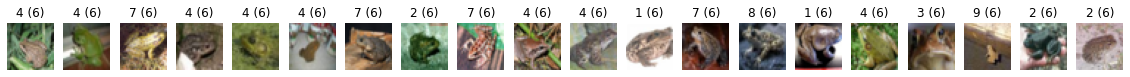

In [103]:
show_failures(predictions, trueclass=6)

We can also compute the confusion matrix to see which image get mixed the most, and look at classification accuracies separately for each class:

In [104]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
cm=confusion_matrix(y_test, numpy.argmax(predictions, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print("%d: %.4f" % (i,j))

Confusion matrix (rows: true classes; columns: predicted classes):

[[480  45  70  10  62   8  20  78 175  52]
 [ 61 482  22  26  35  35  32  66  78 163]
 [ 98  28 232  48 264  63  95 111  43  18]
 [ 31  51  94 207 128 174  85 136  29  65]
 [ 62  26  93  24 501  34  96 118  28  18]
 [ 24  31 102 125 133 290  83 146  45  21]
 [ 10  37  73  65 223  42 421  88  14  27]
 [ 31  35  42  33 126  47  37 564  30  55]
 [165  86  23  17  33  27   9  38 521  81]
 [ 63 166  15  15  29  25  35  76  90 486]]

Classification accuracy for each class:

0: 0.4800
1: 0.4820
2: 0.2320
3: 0.2070
4: 0.5010
5: 0.2900
6: 0.4210
7: 0.5640
8: 0.5210
9: 0.4860


In the next notebook, we'll introduce convolutional layers, which are commonly used for images.

# In-class exercise: improve the accuracy of this model

How can you improve model accuracy by increasing epochs, stacking more layers, or changing the optimizer?